In [1]:
import pandas as pd

In [8]:
en_df = pd.read_csv("train/ntcir17_mednlp-sc_sm_en_train_26_06_23.csv")
fr_df = pd.read_csv("train/ntcir17_mednlp-sc_sm_fr_train_26_06_23.csv")
de_df = pd.read_csv("train/ntcir17_mednlp-sc_sm_de_train_26_06_23.csv")
ja_df = pd.read_csv("train/ntcir17_mednlp-sc_sm_ja_train_26_06_23.csv")

In [9]:
remove_common_name = lambda x: x.split(":")[0]

In [10]:
en_df = en_df.rename(remove_common_name, axis='columns')
fr_df = fr_df.rename(remove_common_name, axis='columns')
de_df = de_df.rename(remove_common_name, axis='columns')
ja_df = ja_df.rename(remove_common_name, axis='columns')

In [11]:
ade_columns = ['C0027497', 'C0011991', 'C0015672', 'C0042963', 'C0003123',
               'C0018681', 'C0015967', 'C0206062', 'C0023895', 'C0012833',
               'C0030193', 'C0002170', 'C0004096', 'C0022658', 'C0020517',
               'C0917801', 'C0009806', 'C0005956', 'C0000737', 'C0010692',
               'C0015230', 'C0149745']

In [12]:
en_df["ade"] = en_df[en_df[ade_columns] > 0].any(axis='columns')

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
en_xtrain, en_xvalid, = train_test_split(en_df, stratify=en_df["ade"], 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [15]:
fr_train = fr_df[fr_df["train_id"].isin(en_xtrain["train_id"])]
de_train = de_df[de_df["train_id"].isin(en_xtrain["train_id"])]
ja_train = ja_df[ja_df["train_id"].isin(en_xtrain["train_id"])]

In [16]:
fr_valid = fr_df[fr_df["train_id"].isin(en_xvalid["train_id"])]
de_valid = de_df[de_df["train_id"].isin(en_xvalid["train_id"])]
ja_valid = ja_df[ja_df["train_id"].isin(en_xvalid["train_id"])]

In [17]:
en_xtrain = en_xtrain.drop(columns=["ade"])

In [18]:
comb_train = pd.concat([en_xtrain, fr_train, de_train, ja_train])
comb_train[ade_columns] = comb_train[ade_columns].astype(float)
comb_train["labels"] = comb_train[ade_columns].values.tolist()
xtrain_ds = comb_train.drop(columns=ade_columns+["train_id"])
xtrain_ds = xtrain_ds.sample(frac=1).reset_index(drop=True)

In [19]:
en_valid = en_xvalid.drop(columns=["ade"])
comb_valid = pd.concat([en_valid, fr_valid, de_valid, ja_valid])
comb_valid[ade_columns] = comb_valid[ade_columns].astype(float)
comb_valid["labels"] = comb_valid[ade_columns].values.tolist()
xvalid_ds = comb_valid.drop(columns=ade_columns+["train_id"])

In [20]:
id2label = {idx:label for idx, label in enumerate(ade_columns)}
label2id = {label:idx for idx, label in enumerate(ade_columns)}

In [21]:
!pip install transformers[torch]==4.28.1 datasets==2.12.0 --q

In [22]:
import datasets
from datasets import Dataset

In [23]:
train_ds = Dataset.from_pandas(xtrain_ds, preserve_index=False)

In [24]:
from transformers import AutoTokenizer
import numpy as np
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

In [25]:
def preprocess_data(examples):
    # take a batch of texts
    # encode them
    encoding = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
    encoding["labels"] = examples["labels"]
    return encoding

In [26]:
train_ds = train_ds.map(preprocess_data, batched=True, remove_columns=train_ds.column_names)

Map:   0%|          | 0/28668 [00:00<?, ? examples/s]

In [27]:
train_ds.set_format("torch")

In [28]:
valid_ds = Dataset.from_pandas(xvalid_ds, preserve_index=False)
valid_ds = valid_ds.map(preprocess_data, batched=True, remove_columns=valid_ds.column_names)
valid_ds.set_format("torch")

Map:   0%|          | 0/3188 [00:00<?, ? examples/s]

In [29]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(ade_columns),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.out

In [30]:
from sklearn.metrics import f1_score

In [31]:
import torch
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs > threshold)] = 1
    # finally, compute metrics
    y_true = labels
    
    return {'f1': f1_score(labels.sum(axis=1)>0,
                           y_pred.sum(axis=1)>0)}

In [32]:
def compute_metrics(p):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [33]:
from transformers import TrainingArguments, Trainer
batch_size = 32
args = TrainingArguments(
    f"roberta-finetuned-pharma",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    #push_to_hub=True,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
outputs = model(input_ids=train_ds['input_ids'][0].unsqueeze(0), labels=train_ds[0]['labels'].unsqueeze(0))
print(outputs)

SequenceClassifierOutput(loss=tensor(0.6636, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.2689, -0.3159,  0.5139,  0.3286,  0.3396, -0.3322, -0.5178,  0.1577,
          0.1113, -0.4822, -0.4981, -0.4492, -0.2927,  0.4772, -0.1523,  0.3354,
          0.1568, -0.4443, -0.1756,  0.1426, -0.7459,  0.0500]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [35]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.093400,0.033384,0.790822
2,0.024500,0.026816,0.828194
3,0.014500,0.026200,0.839941
4,0.008700,0.030091,0.838991
5,0.005700,0.033331,0.841646
6,0.003800,0.034560,0.843098
7,0.002700,0.038096,0.834835
8,0.001700,0.037642,0.839980


In [37]:
trainer.save_model()

In [38]:
eval_loss = []
eval_f1 = []
for log_dict in trainer.state.log_history:
    if 'eval_loss' in log_dict:
        eval_loss.append(log_dict['eval_loss'])
        eval_f1.append(log_dict['eval_f1'])

/tmp/ipykernel_7973/2270467032.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


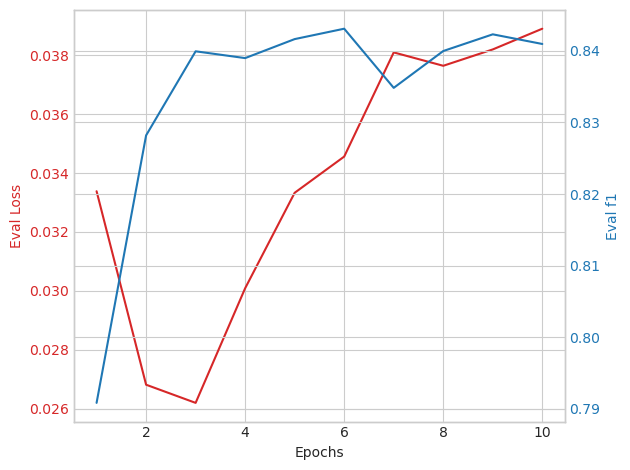

In [39]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
%matplotlib inline
x = np.linspace(1, 10, 10)
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Eval Loss', color=color)
ax1.plot(x, eval_loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Eval f1', color=color)  # we already handled the x-label with ax1
ax2.plot(x, eval_f1, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('xlm-roberta-f2-loss.png')